In [290]:
from pathlib import Path
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [291]:
# Load feature tables
test_path = Path("../data/leave-one-group-out-split/splits/").glob("test*.tsv")
train_path = Path("../data/leave-one-group-out-split/splits/").glob("train*.tsv")

test_tables = [pd.read_csv(table, sep="\t") for table in test_path]
train_tables = [pd.read_csv(table, sep="\t") for table in train_path]

In [ ]:
def format_splits(train_df, test_df, split):
    le = LabelEncoder()
    train_df["classification_x"] = le.fit_transform(train_df["classification_x"])
    test_df["classification_x"] = le.fit_transform(test_df["classification_x"])

    ## Check to see if the encodings are consistent between test and train split
    # train_encodings = sorted(
    #     set(
    #         zip(
    #             train_df["classification_x"],
    #             le.inverse_transform(train_df["classification_x"]),
    #         )
    #     )
    # )
    # test_encodings = sorted(
    #     set(
    #         zip(
    #             test_df["classification_x"],
    #             le.inverse_transform(test_df["classification_x"]),
    #         )
    #     )
    # )

    # print("Train encodings:")
    # for enc, label in train_encodings:
    #     print(f"{enc}: {label}")

    # print("\nTest encodings:")
    # for enc, label in test_encodings:
    #     print(f"{enc}: {label}")

    # if train_encodings != test_encodings:
    #     print("! Encodings do not match")

    # Select feature columns
    feature_cols = train_df.drop(
        columns=["Unnamed: 0", "Geneid", "DNASequence", "classification_x", "group"]
    ).columns

    X_train = train_df[feature_cols].copy()
    y_train = train_df["classification_x"].copy()

    X_test = test_df[feature_cols].copy()
    y_test = test_df["classification_x"].copy()

    return X_train, y_train, X_test, y_test, le, split


def run_xgboost(X_train, y_train, X_test, y_test, le, split):
    bst = XGBClassifier(objective="binary:logistic", seed=42)
    # fit model
    bst.fit(X_train, y_train)

    # Print confusion matrix
    titles_options = [
        ("Confusion matrix, without normalization", None),
        ("Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            bst, X_test, y_test, display_labels=le.classes_, normalize=normalize
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()

Split 0
Confusion matrix, without normalization
[[18 87 57]
 [ 5 77 35]
 [ 0  4  5]]
Normalized confusion matrix
[[0.11111111 0.53703704 0.35185185]
 [0.04273504 0.65811966 0.2991453 ]
 [0.         0.44444444 0.55555556]]


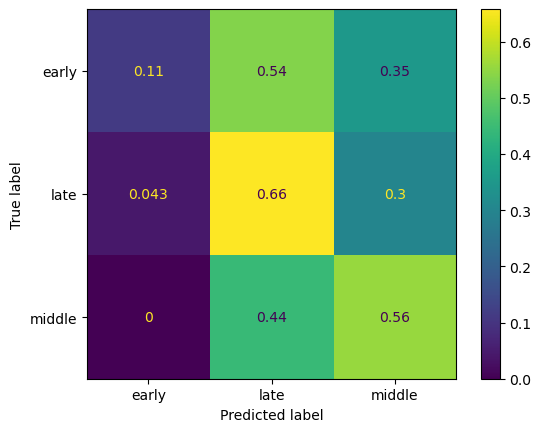

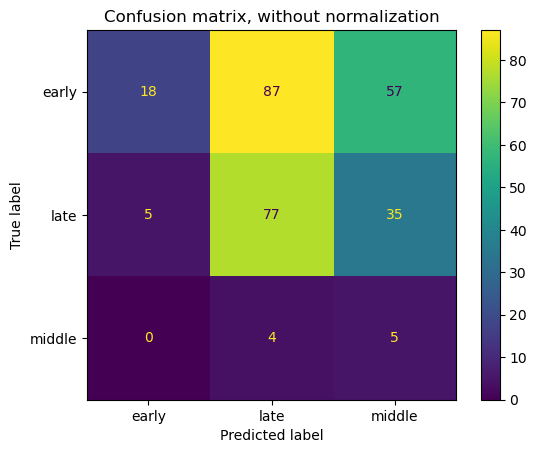

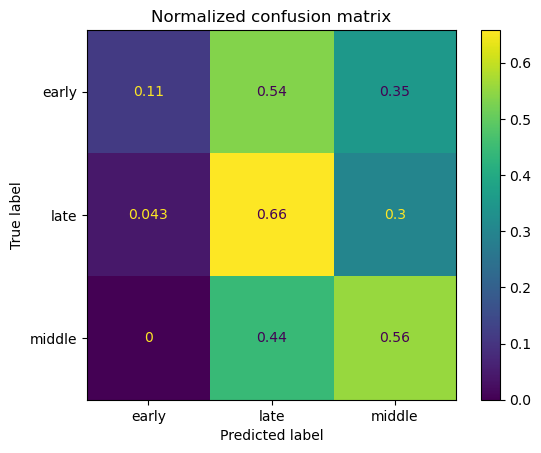

(288,)
Split 1
Confusion matrix, without normalization
[[ 9  0  0]
 [ 4 16  3]
 [ 6 13  3]]
Normalized confusion matrix
[[1.         0.         0.        ]
 [0.17391304 0.69565217 0.13043478]
 [0.27272727 0.59090909 0.13636364]]


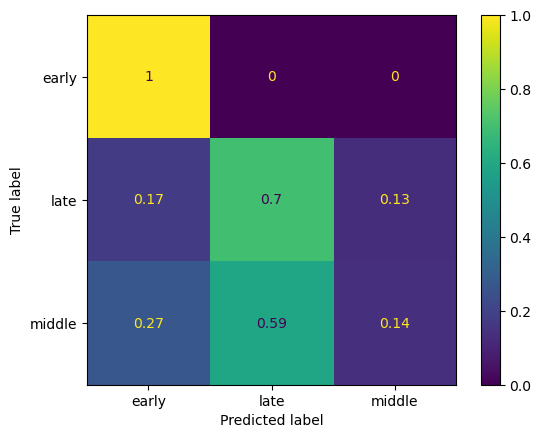

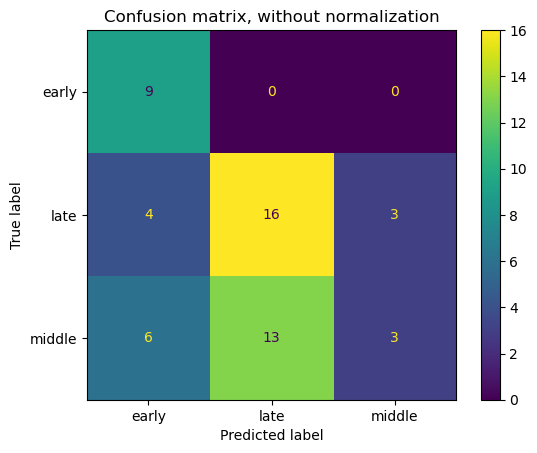

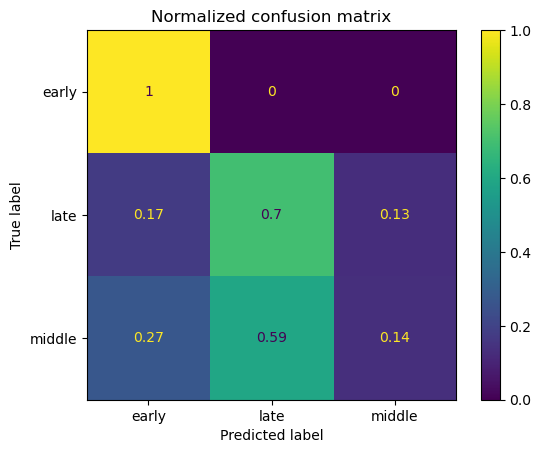

(54,)
Split 2
Confusion matrix, without normalization
[[ 7  0  0]
 [ 0 21  0]
 [ 0  0 32]]
Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


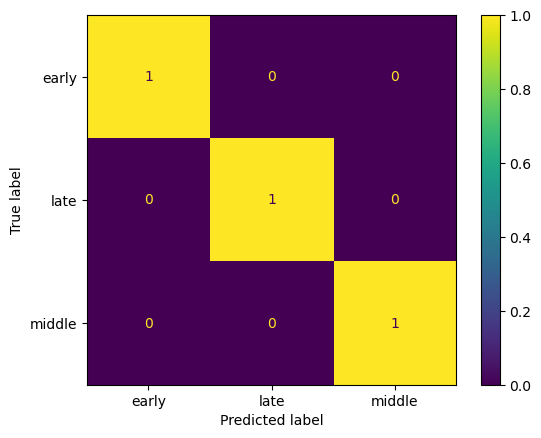

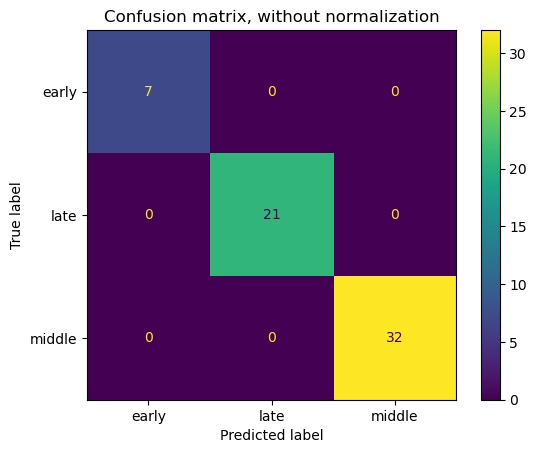

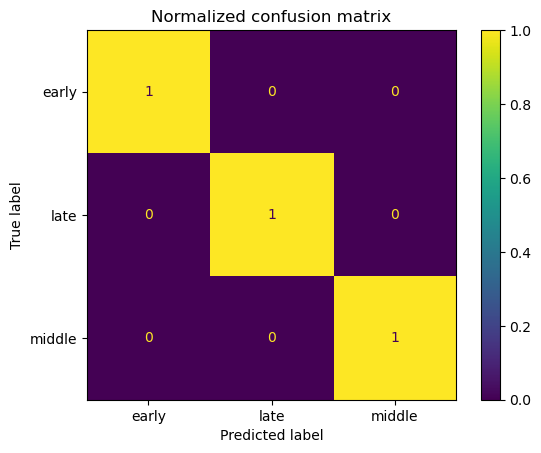

(60,)
Split 3
Confusion matrix, without normalization
[[ 78   0   0]
 [  0  59   0]
 [  0   0 100]]
Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


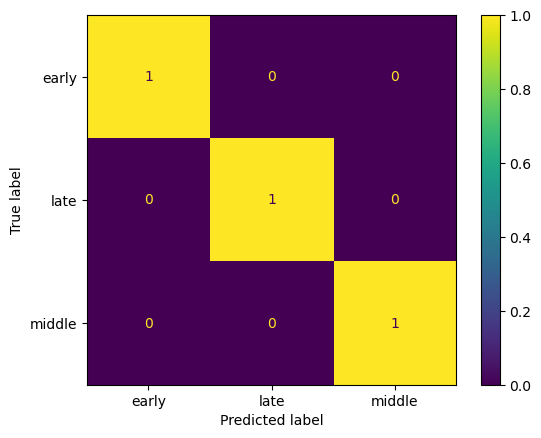

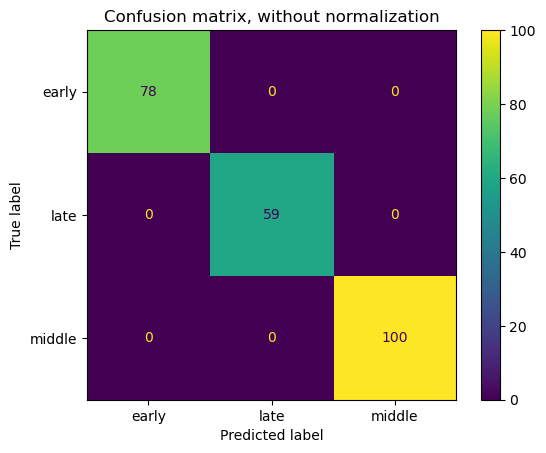

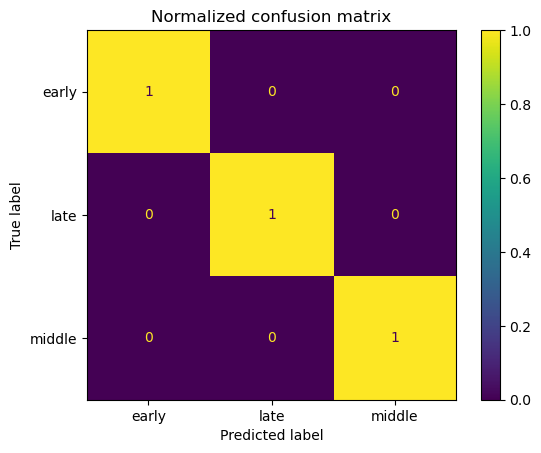

(237,)
Split 4
Confusion matrix, without normalization
[[ 3  0  0]
 [ 0 32  0]
 [ 0  0 19]]
Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


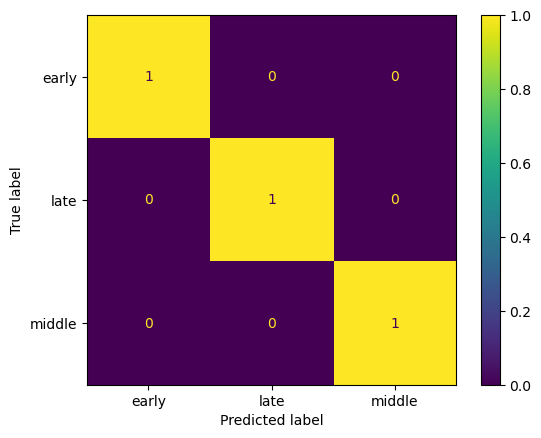

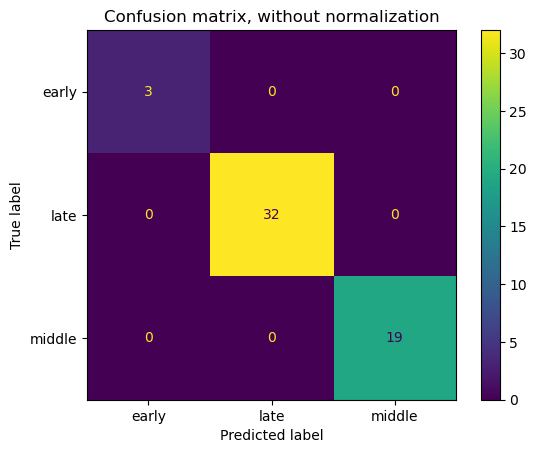

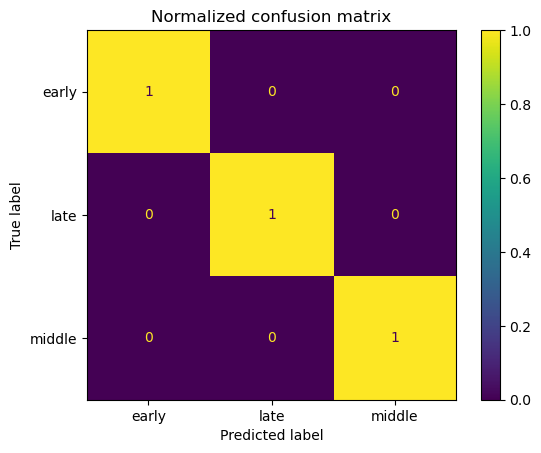

(54,)
Split 5
Confusion matrix, without normalization
[[ 46   0   0]
 [  0 208   1]
 [  0   0 206]]
Normalized confusion matrix
[[1.         0.         0.        ]
 [0.         0.99521531 0.00478469]
 [0.         0.         1.        ]]


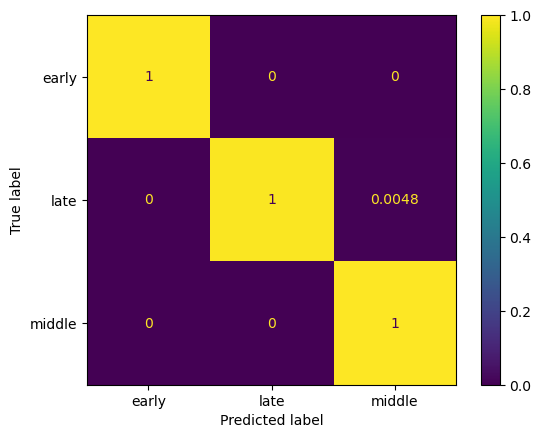

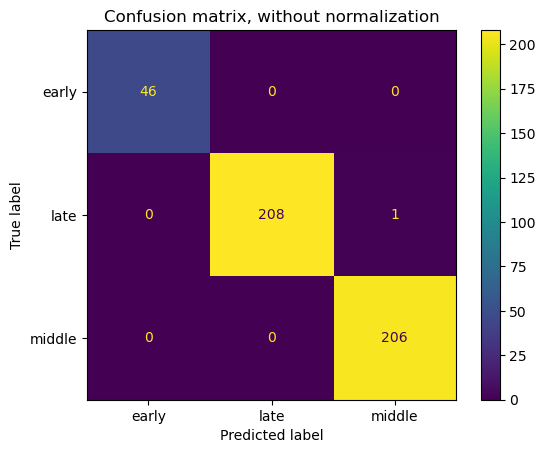

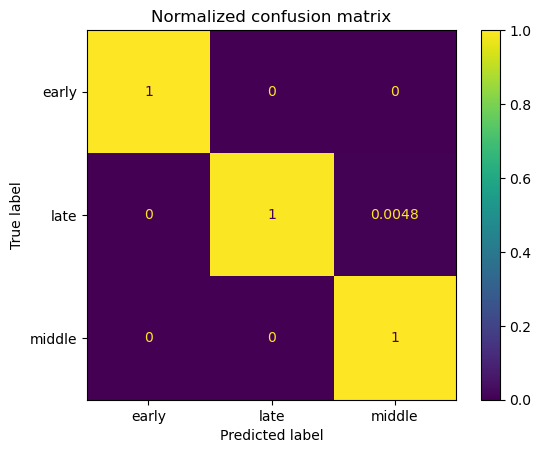

(461,)


In [293]:
for i, (train_df, test_df) in enumerate(zip(train_tables, test_tables)):
    print(f"Split {i}")
    run_xgboost(*format_splits(train_df, test_df, i))
